In [3]:
using  Luna
import Luna.PhysData: wlfreq    
import FFTW                    
import Luna: Hankel  
import NumericalIntegration: integrate, SimpsonEven          
import Dates                   
using  DelimitedFiles
using  LaTeXStrings
using LsqFit
using Printf
using DSP
using Optim
using HDF5
#using Polynomials
using Roots

import PyPlot as plt
plt.pygui(true)

true

In [4]:
# function to that puts the pulse phase to NaN values where the Intensity is very low and the phase therefore meaningless.
# you can define the threshold below which the phase is put to NaN.
# this function is useful when one wants to fit the phase with a polynomial to extract for example the GDD value.

function blank_phase(x, I, ϕ; level=0.05)
    
    # works for 1D and 2D I, ϕ arrays
    
    if size(I) != size(ϕ)
        error("Error: I and ϕ have to be of the same size.")
    end
    
    num_col = size(I, 2)  # Number of columns in I and ϕ
    ϕ_blanked = similar(ϕ)  # Allocate array to store results

    # Iterate over each column in I
    for i in 1:num_col
        I_col = I[:, i]
        ϕ_col = ϕ[:, i]

        val = level * maximum(I_col)    # threshold intensity
        maxidx = argmax(I_col)
        xmax = x[maxidx]               

        # find left and right indices between which intensity is above
        # lefti = findlast((x .< xmax) .& (I_col .< val))
        # righti = findfirst((x .> xmax) .& (I_col .< val))

        lefti = findfirst((x .< xmax) .& (I_col .> val))
        righti = findlast((x .> xmax) .& (I_col .> val))

        ϕ_blanked_col = copy(ϕ_col)
        
        if !isnothing(lefti)
            ϕ_blanked_col[1:lefti-1] .= NaN
        end
        if !isnothing(righti)
            ϕ_blanked_col[righti+1:end] .= NaN
        end

        # shift phase values to zero (convinient for comparing the phase graphs)
        ϕ_blanked_col .-= minimum(filter(!isnan, ϕ_blanked_col))

        ϕ_blanked[:, i] = ϕ_blanked_col
    end
    
    return ϕ_blanked
end

blank_phase (generic function with 1 method)

In [5]:
# function that unwraps the pulse phase.
# It evoids errors in the unfolding that can occur due to the very large linear contribution of the phase.
# with the key word argument "linear" you can set whether the linear contribution should be kept or discarded after unwrapping.
# usually the linear part is not of much interest.

function unwrap_phase(E_complex; linear=false)
    
    E = copy(E_complex)

    Nt = length(grid.t)
    dt = grid.t[2] - grid.t[1]

    τ_shift = -Nt*dt/2
    E .*= exp.(-1im .*grid.ω .*τ_shift)      # eliminating large linear contribution by shifting to -t_max before unwrapping

    ϕω = unwrap(-angle.(E); dims=1)     

    if linear == true
        ϕω .-= grid.ω .*τ_shift      # putting back linear part of the phase
    end

    return ϕω
end

unwrap_phase (generic function with 1 method)

## Reading in Esmerandos input

In [6]:
data = readdlm("esm_input_pulse.txt", skipstart=1)

t_esm = data[:, 1]
real_esm = data[:, 2]
imag_esm = data[:, 3]
Et_esm = real_esm + 1im*imag_esm

8192-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


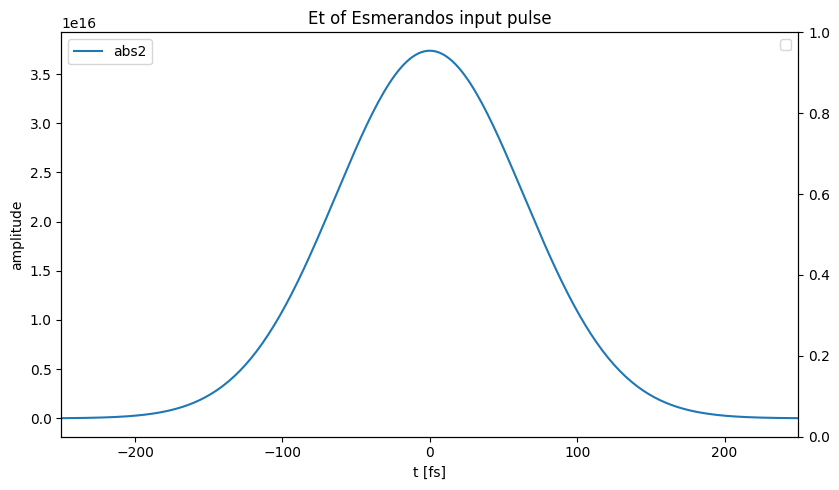

In [7]:
fig, ax1 = plt.subplots(figsize=(8.5, 5))
    ax1.set_title("Et of Esmerandos input pulse")
    # ax1.plot(t_esm.*1e15, real.(Et_esm), label="real")
    # ax1.plot(t_esm.*1e15, imag.(Et_esm), label="imaginary")
    ax1.plot(t_esm.*1e15, abs2.(Et_esm), label="abs2")
    ax2 = ax1.twinx()
    # ax2.plot(t_esm.*1e15, ϕt_blanked, label="ϕt")
    ax1.set_xlim(-250 , 250)
    # ax1.set_ylim(0,)#, 50)
    ax1.set_xlabel("t [fs]")
    ax1.set_ylabel("amplitude")
    # ax2.set_ylabel("phase [rad]")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()

In [8]:
data = readdlm("esm_input_spectrum.txt", skipstart=1)

ω_esm = data[:, 1]
real_esm = data[:, 2]
imag_esm = data[:, 3]
Eω_esm = real_esm + 1im*imag_esm

8192-element Vector{ComplexF64}:
                 0.0 + 0.0im
                 0.0 - 3.88128682971001e-7im
                 0.0 + 6.36093318462372e-7im
                 0.0 + 3.68803739547729e-7im
  -3.814697265625e-6 - 4.45172190666199e-7im
                 0.0 - 5.33647835254669e-7im
                 0.0 - 3.27825546264648e-7im
 -1.9073486328125e-6 + 7.54371285438538e-8im
                 0.0 + 9.35979187488556e-7im
                 0.0 - 1.86264514923096e-8im
                     ⋮
                 0.0 + 1.86264514923096e-8im
                 0.0 - 9.35979187488556e-7im
 -1.9073486328125e-6 - 7.54371285438538e-8im
                 0.0 + 3.27825546264648e-7im
                 0.0 + 5.33647835254669e-7im
  -3.814697265625e-6 + 4.45172190666199e-7im
                 0.0 - 3.68803739547729e-7im
                 0.0 - 6.36093318462372e-7im
                 0.0 + 3.88128682971001e-7im

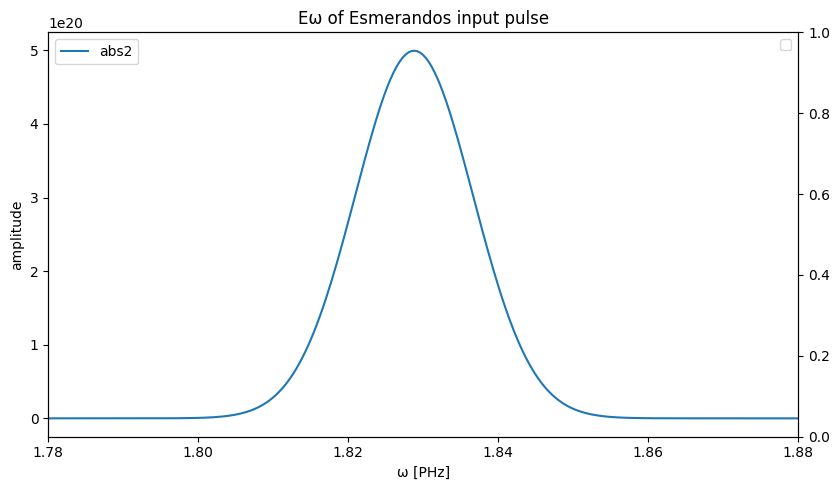

In [9]:
fig, ax1 = plt.subplots(figsize=(8.5, 5))
    ax1.set_title("Eω of Esmerandos input pulse")
    # ax1.plot(ω_esm.*1e-15, real.(Eω_esm), label="real")
    # ax1.plot(ω_esm.*1e-15, imag.(Eω_esm), label="imaginary")
    ax1.plot(ω_esm.*1e-15, abs2.(Eω_esm), label="abs2")
    ax2 = ax1.twinx()
    # ax2.plot(ω_esm.*1e15, ϕω_blanked, label="ϕt")
    ax1.set_xlim(1.78 , 1.88)
    # ax1.set_ylim(0,)#, 50)
    ax1.set_xlabel("ω [PHz]")
    ax1.set_ylabel("amplitude")
    # ax2.set_ylabel("phase [rad]")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()

## Creating input pulse in luna

In [10]:
# ----------------- SIMULATION OPTIONS -----------------

    out_path = joinpath("output","run_"*Dates.format(Dates.now(), "yyyy_mm_dd__HH_MM_SS"))
    # mkdir(out_path)

    #in_dir = "tangerine_FROG_1kHz"
    in_dir = joinpath("input", "tangerine_FROG_50kHz")

    file_FROG_Et = "Ek.dat"
    file_FROG_Eω = "Speck.dat"

    path_FROG_Eω = joinpath(in_dir, file_FROG_Eω)


    # file_FROG_spec = joinpath("input", "Speck.dat")                   # name of complex IR FROG input spectrum file 
    # file_FROG_pulse = joinpath("input", "20220505_retrievedpulse.txt")

    # mirror data files
    path_m1 = joinpath("input", "mirrordata_0fs2.txt") # "mirrordata_0fs2.txt"; "mirror_R_100_GDD_0fs2.txt"; "mirror_R_data_GDD_0fs2.txt"
    path_m2 = joinpath("input", "mirrordata_-30fs2.txt") # "mirrordata_-30fs2.txt"; "mirror_R_100_GDD_-30fs2.txt"; "mirror_R_data_GDD_-30fs2.txt"

    #comments = "Simulation with reflectivity from mirror data file but GDD set constant (0 and -30.0 fs2)." #constant 100% reflectivity but GDD taken from mirror data file."
    comments = " "

# ----------------- SETTING RESULT PROCESSING -----------------
    use_FROG_spectrum = false
    include_nl_focusing = false
    show = false                    # if true: show plots
    show_title = true
    save = false
    save_HDF5 = false
    use_pdf = false
    norm = true
    disable_latex = true # if true: disable latex rendering of plots (saves time but might result in some labels or title being displayed incorrectly)


    @eval import PyPlot: pygui, plt, PyDict, matplotlib 
        close("all")
        pygui(true)

        # set plot formatting 
        rcParams = PyDict(matplotlib."rcParams") # get rcParams 
        if disable_latex==false  rcParams["text.usetex"] = true end # enable LaTeX renadering
        rcParams["mathtext.fontset"] = "cm" # use LateX font for maths
        rcParams["font.family"] = "STIXGeneral" # use LateX font for text
        rcParams["font.size"] = 16 # set standard font size 
        fig_dim = 2* [3.14961, 2.3622075] # for 8cm width ; double for 16cm width  


        #plt.rc("text", usetex=false)


# ----------------- SETTING PARAMETERS -----------------

    # pulse parameters
    λ0 = 1030e-9        # central wavelength [m]
    τ = 150e-15         # pulse duration [s]; ignored if FROG spectrum is used
    E_pulse = 250e-6    # pulse energy [J]
    #w0 = 150e-6         # beam waist at focus [m]      # instead calculated later
    M2 = 1.0           # beam quality                 # not yet implemented; how would you do that?

    # MPC parameters
    Nrt = 15           # number of round trips
    Npass = 2*Nrt       # number of passes

    mtype = :spherical  # mirror type, either :spherical or :parabolic
    R = 200e-3          # mirror radius of curvature [m]
    k = Nrt-2           # for k = Nrt-1 MPC operation is closest to the stability edge and wm is maximized reducing mirror damage 
    #L = 380.1934e-3 #382.7090915285e-3 #395.6295201468e-3           # MPC cell length [m]
    L = R*(1-cos(pi*k/Nrt))                                       # MPC cell length [m] calculated (see ref.[2])
    C = L/R

    propz = -L/2         # propagation distance from the waist [m] (distance between mirror position and focal position)
    z_vals = L .* [0, 1/2, 1]     # points along the cell at which to investigate beam evolution [m]

    println("L = ", L)
    println("C = ", C)

    pres = 1.5 #10e-10 #1.5               # gas pressure [bar]
    gas = :Kr           # gas type
    N0, n0, n2 = Tools.getN0n0n2(PhysData.wlfreq(λ0), gas; P=pres, T=PhysData.roomtemp)        # gas number density, linear and nonlinear refractive index [m^2/W]
    println("n2 = ", n2)

    if include_nl_focusing == true
        P_peak = 0.94*E_pulse/τ             # peak power; 0.94 for gaussian pulses (see ref.[3])
        P_crit = 3.77*λ0^2/(8*pi*n0*n2)     # critical power; above which beam collapses
        σ = 1-P_peak/(sqrt(2)*P_crit)       # nonlinear correction factor that accounts for self focusing/Kerr lensing
        println("σ = ",σ)
    else
        σ=1
    end

    ion = true         # if true: enable ionisation response, if false: disable ionisation 
    ion_model="PPT"    # set to "ADK" or "PPT" (has no effect if ion==false); "ADK" is less accurate at low intensities but faster; "PPT" may crash at very high intensities

    
    # simulation grid parameters
    λlims = (600e-9, 1500e-9) #(700e-9, 1400e-9) #(700e-9, 1400e-9) # # wavelength range of interest [m]
    trange = 10*τ #10*τ #300.0e-15 #0.05e-12    # total extent of time window required [s], default was 50fs (NOTE: if this is too short, the range is extended automatically; this value was taken from an older version of the code; no justification!)
    Nz = 201                            # number of points along z at which the spectrum is saved
    

    # calculate theoretical beam size in the MPC (as in ref[2] eq. 3&4 and ref.[1] eq. 2&6)

        # beam waist in the focus
        #w0 = sqrt(M2*R*λ0 * sqrt(σ*C*(2-C)) /(2*pi))         # ! this value is used to define the gaussian beam in the beginning of the simulation
        w0 = sqrt(M2*λ0*L * sqrt(σ*(2*R/L -1)) /(2*pi))   #123.62e-6 #125e-6       # these two eq. for w0 should give the same value                                         
        @printf("Input focal spot radius w0 = %.2f µm\n", w0*1e6)

        # beam waist on the mirror
        # wm = sqrt(M2*R*λ0 * sqrt(C/(2-C)) /pi) 
        wm = w0*sqrt(2*R/(2*R-L))
        @printf("Calculated spot radius at the mirror location wm = %.2f µm\n", wm*1e6)


    # initialize arrays to track beam size and intensity at L/2 and L (in the center of the cell and at the mirror position)
        w_0 = []
        w_m = []

        I_0 = []
        I_m = []          


    # Hankel transformation
    R_hankel = 3.0*wm           # aperture radius for Hankel transform (assume field ≈0 for r>R ) [m]  
    N_hankel = 128 #256 #512 #1024             # sample size for Hankel tansform grid 

# ----------------- SET SIMULATION GRID ----------------------------

    q = Hankel.QDHT(R_hankel, N_hankel, dim=2)                  # set up discrete Hankel transform matrix, transformation done along 2nd dimension 
    q_1D = Hankel.QDHT(R_hankel, N_hankel, dim=1)               # to be applied to arrays that where integrated over ω, so r becomes 1rst dimension
    rsym = Hankel.Rsymmetric(q)                                 # sampled radii [m] mirrored around and including r=0 so that rsym = [–rn, ...-r2, -r1, 0, r1, r2, ..., rn]

    grid = Grid.RealGrid(L, λ0, λlims, trange)               # set up time & space grid for gradient approximation 
                       
    energyfun, energyfun_ω = Fields.energyfuncs(grid, q)    # "energyfun" gives total energy in a field E(t); energyfun_ω is needed in case field is defined via FROG spectrum  
    energyfun_1D, energyfun_ω_1D = Fields.energyfuncs(grid, q_1D)

# ----------------- SET NONLINEAR EFFECTS ----------------------------

    ionpot = PhysData.ionisation_potential(gas)                 # set gas ionisation potential   

    if ion_model=="ADK"
        ionrate = Ionisation.ionrate_fun!_ADK(gas)                  # set gas ionisation rate (ADK)
    elseif ion_model=="PPT"
        ionrate = Ionisation.ionrate_fun!_PPTcached(gas, λ0)        # set gas ionisation rate (PPT)
    end    

    n_gas = PhysData.ref_index_fun(gas, pres)                       # refractive index of the gas for given pressure (no pressure profile, pressure is constant)

    linop = LinearOps.make_const_linop(grid, q, n_gas)              # generate linear operator for pulse-propagation equation
    normfun = NonlinearRHS.const_norm_radial(grid, q, n_gas)        # generate normalisation function for radial symmetry


    # * * * SET KERR EFFECT AND/OR PLASMA FORMATION 
    if ion == true                             # nonlinear response function with ionisation and Kerr effect
        responses = (Nonlinear.Kerr_field(PhysData.γ3_gas(gas)),     
                Nonlinear.PlasmaCumtrapz(grid.to, grid.to, ionrate, ionpot),)  
    elseif ion == false                        # nonlinear response function without ionisation, just Kerr effect
        responses = (Nonlinear.Kerr_field(PhysData.γ3_gas(gas)),)    
    end 

# ---------------- SET GAS DENSITY ----------------
    densityfun = let dens0=PhysData.density(gas, pres)      # pressure is constant in MPC
        z -> dens0 
    end

# ---------------- SET UP SIMULATION -------------------
    if use_FROG_spectrum==true
        inputs = () # leave input field empty as we will be defined later by the FROG spectrum

    else
        # input field
        # to get a converging beam, we define a Gaussian spot with size w0
        # and then *back-propagate* by L/2 i.e. by half of our propagation window
        # this means the nominal focus is halfway through our propagation in this example
        inputs = Fields.GaussGaussField(λ0=λ0, τfwhm=τ, energy=E_pulse, w0=w0, propz=propz)
    end

    Eωk, transform, FT = Luna.setup(grid, q, densityfun, normfun, responses, inputs)  # set up propagation; Eωk is overwritten when FROG spectrum is used

L = 0.38270909152852023
C = 1.913545457642601
n2 = 3.4199449874306914e-23


Input focal spot radius w0 = 115.48 µm
Calculated spot radius at the mirror location wm = 555.42 µm


┌ Info: Freq limits 0.20 - 0.50 PHz
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:40
┌ Info: Samples needed: 4496.89, samples: 8192, δt = 333.56 as
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:44
┌ Info: Requested time window: 1500.0 fs, actual time window: 2732.6 fs
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:46
┌ Info: Grid: samples 4096 / 8192, ωmax 4.71e+15 / 9.42e+15
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:78
┌ Info: Found cached PPT rate for 13.99 eV, 1030.0 nm
└ @ Luna.Ionisation C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Ionisation.jl:145
┌ Info: Found FFTW wisdom at C:\Users\muelderk\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcache_1threads
└ @ Luna.Utils C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Utils.jl:90
┌ Info: FFTW wisdom saved to C:\Users\muelderk\.julia\scratchspaces\30eb0fb0-5147-11e9-3356-d75b018717ce\lunacache\FFTWcac

(ComplexF64[-7.709023818771199e-12 + 0.0im -7.483725333236152e-12 + 0.0im … -8.061137790072579e-16 + 0.0im -4.0678940281200884e-16 + 0.0im; 3.4805105031038425e-12 - 6.566315758894409e-12im 6.159710101499934e-12 + 3.755065471698207e-12im … -3.274487329673874e-16 - 1.4255751023183056e-16im -1.7628007947248197e-16 - 6.52199449491916e-17im; … ; -5.426767662311183e-12 + 6.283609226646848e-14im -5.258262350673585e-12 + 3.4604100546010465e-13im … 9.645280925939909e-16 + 3.744582237182096e-16im 2.1304048329719006e-16 + 4.815323492884322e-16im; 5.573920279767466e-12 - 7.072204108330619e-14im 5.399351760869365e-12 - 3.6147914017472345e-13im … -2.529242694406482e-15 - 2.8234271193672633e-15im 8.10226270651553e-17 - 1.9489689002899186e-15im], TransRadial
  grid type: Luna.Grid.RealGrid
  time grid size: 4096 / 8192
  radial points: 128
  aperture: 0.0016662596224075788
  responses: Luna.Nonlinear.var"#Kerr#1"{Float64}
    Luna.Nonlinear.PlasmaCumtrapz{Luna.Ionisation.var"#ionrate!#20"{Float64, Flo

In [11]:
# Eωk is complex and the entries are non zero valued
println("size(Eωk) = ", size(Eωk))
println("typeof(Eωk) = ", typeof(Eωk))
println(Eωk[1000:1010, 1])

size(Eωk) = (2049, 128)
typeof(Eωk) = Matrix{ComplexF64}
ComplexF64[-1.998622637533027e-12 + 5.292928557548879e-14im, 1.1847140935152253e-12 - 4.2711493787037063e-14im, -3.8763590934780776e-13 + 1.0981956315135113e-13im, -1.6282865407878088e-13 - 2.392735600471368e-14im, 5.368425379150727e-13 + 2.862051691672987e-14im, -5.097896766725451e-13 - 3.3954980505926724e-14im, 1.530211912141256e-13 - 6.9166081197493195e-15im, 6.556930338544424e-13 - 9.228459659817614e-16im, -1.887691572461694e-12 + 5.888698165112936e-14im, 3.462009352613151e-12 - 8.202057365970271e-14im, -5.2925729297351066e-12 + 1.4077569884240478e-13im]


## input Eω in luna at r=0 and integrated over r

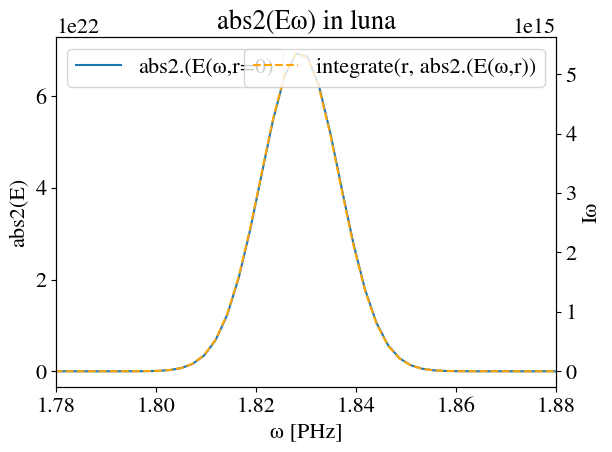

In [224]:
Eωr0 = dropdims(Hankel.onaxis(Eωk, q), dims=2);     # Eω at r=0
Eω = Hankel.integrateK(Eωk, q; dim=2)               # integrated over r (technically k)
Iω = Hankel.integrateK(abs2.(Eωk), q; dim=2)


fig, ax1 = plt.subplots()
    ax1.set_title("abs2(Eω) in luna")
    # ax1.plot(grid.ω.*1e-15, abs2.(Eω), label="integrated over r")
    # ax1.plot(grid.ω.*1e-15, real.(Eω), label="real")
    # ax1.plot(grid.ω.*1e-15, imag.(Eω), label="imaginary")
    ax1.plot(grid.ω.*1e-15, abs2.(Eωr0), label="abs2.(E(ω,r=0)")#, linestyle="--", color="orange")
    # ax1.plot(grid.ω.*1e-15, real(Eωr0), label="real(Eωr0)", linestyle="--")#, color="orange")
    # ax1.plot(grid.ω.*1e-15, imag(Eωr0), label="imag(Eωr0)", linestyle="--")#, color="orange")
    ax2 = ax1.twinx()
    ax2.plot(grid.ω.*1e-15, Iω, label="integrate(r, abs2.(E(ω,r))", linestyle="--", color="orange")
    ax1.set_xlim(1.78 , 1.88)
    #ax2.set_ylim(-50, 50)
    ax1.set_xlabel("ω [PHz]")
    ax1.set_ylabel("abs2(E)")
    ax2.set_ylabel("Iω")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()

    # why are they the same? should the integrated version be higher in values/intensity?

## Comparison input Eω of Esmerando vs. luna (integrated over r)

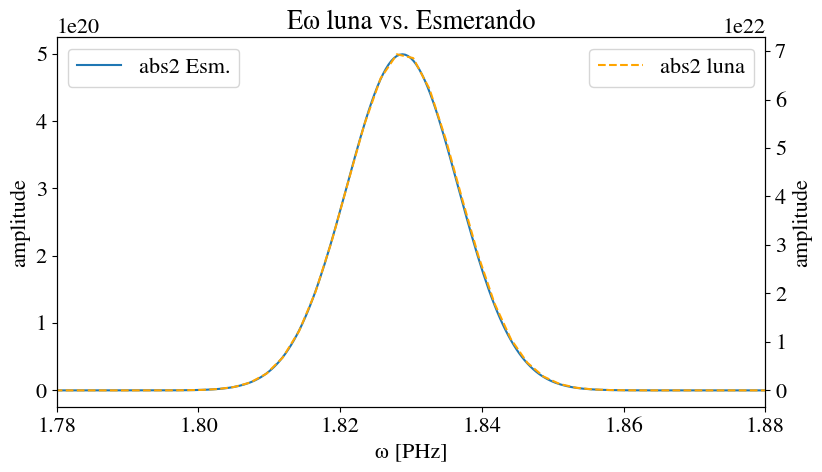

In [20]:
# prefac = 2*pi*2*pi/grid.ω[end]^2
# prefac = 2*pi*2*pi
# prefac = 2*pi*PhysData.c*PhysData.ε_0/2
# println(prefac)

fig, ax1 = plt.subplots(figsize=(8.5, 5))
    ax1.set_title("Eω luna vs. Esmerando")
    # ax1.plot(ω_esm.*1e-15, real.(Eω_esm), label="real")
    # ax1.plot(ω_esm.*1e-15, imag.(Eω_esm), label="imaginary")
    ax1.plot(ω_esm.*1e-15, abs2.(Eω_esm), label="abs2 Esm.")
    ax2 = ax1.twinx()
    # ax2.plot(grid.ω.*1e-15, prefac.*abs2.(Eω), linestyle="--", color="orange", label="abs2 luna")
    ax2.plot(grid.ω.*1e-15, abs2.(Eω), linestyle="--", color="orange", label="abs2 luna")
    ax1.set_xlim(1.78 , 1.88)
    ax2.set_xlim(1.78 , 1.88)
    # ax1.set_ylim(0,)#, 50)
    ax1.set_xlabel("ω [PHz]")
    ax1.set_ylabel("amplitude")
    ax2.set_ylabel("amplitude")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()

0.0083391023799538


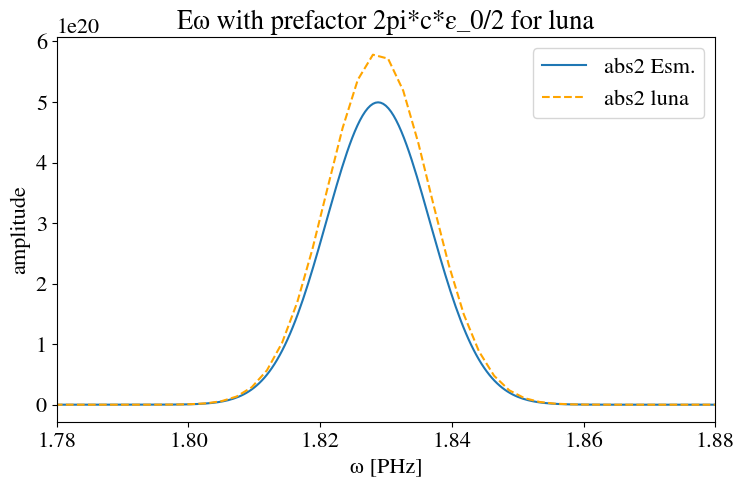

In [21]:
prefac = 2*pi*PhysData.c*PhysData.ε_0/2
println(prefac)

plt.figure(figsize=(8.5, 5))
plt.title("Eω with prefactor 2pi*c*ε_0/2 for luna")
plt.plot(ω_esm.*1e-15, abs2.(Eω_esm), label="abs2 Esm.")
plt.plot(grid.ω.*1e-15, prefac.*abs2.(Eω), linestyle="--", color="orange", label="abs2 luna")
plt.xlim(1.78 , 1.88)
plt.xlabel("ω [PHz]")
plt.ylabel("amplitude")
plt.legend()
plt.gcf()

In [127]:
# tranforming to real space
Eωr = q \ Eωk

2049×128 Matrix{ComplexF64}:
  -0.00115132+0.0im          …  1.65653e-18+0.0im
 -0.000827453+0.000546982im        4.656e-8+1.10118e-6im
 -0.000174261+0.000295785im      7.65893e-7+1.44911e-6im
   -3.0944e-5-2.29959e-5im        6.1012e-6-6.41392e-6im
   8.07775e-6+1.98398e-5im      -4.78195e-7-2.55829e-6im
   3.47018e-6-4.93503e-6im   …  -1.55688e-6-3.32145e-7im
    5.6708e-6+4.43531e-6im       3.49547e-7-3.20234e-7im
  -5.15116e-5-9.90508e-5im      -9.06195e-7+1.69025e-6im
   1.68465e-5+0.000158693im      1.34289e-6+1.71096e-6im
  -0.00023799-9.46416e-5im      -7.91468e-7-4.03965e-6im
             ⋮               ⋱  
   1.72249e-5-3.30752e-5im   …  -3.00234e-8-4.16824e-7im
  -2.91359e-5+5.11648e-5im       3.69994e-7+4.92681e-7im
   4.89969e-5-8.58952e-5im        2.0492e-7+3.44841e-8im
  -7.38373e-5+0.000133236im      5.10644e-7-1.74793e-7im
  0.000106591-0.000194194im     -7.07116e-7+2.38685e-7im
 -0.000139255+0.000253568im  …   8.27944e-8+1.09897e-7im
  0.000171692-0.000307787im     -

In [182]:
println(size(abs2.(Eωr)))
println(typeof(abs2.(Eωr)))
println(typeof(grid.ω))
println(size(grid.ω))
println(typeof(q.r))
println(size(q.r))

Iωr_norm = zeros(size(Eωr))
for ri in length(q.r)
    Iωr_norm[:, ri] = Maths.normbymax(abs2.(Eωr[:, ri]))
end

println(typeof(Iωr_norm))
println(size(Iωr_norm))

(2049, 128)
Matrix{Float64}
Vector{Float64}
(2049,)
Vector{Float64}
(128,)
Matrix{Float64}
(2049, 128)


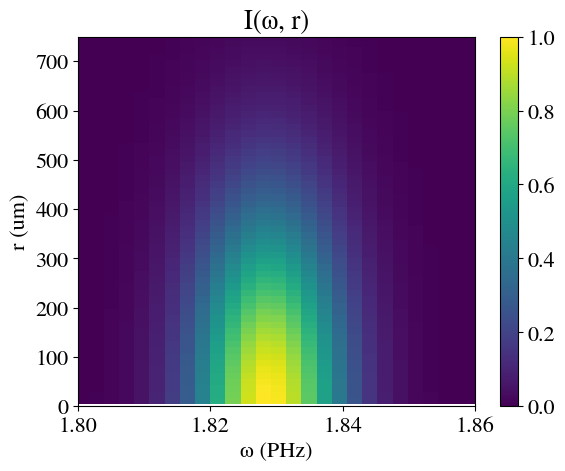

In [192]:

plt.figure()
plt.pcolormesh(grid.ω.*1e-15, q.r.*1e6, Maths.normbymax(abs2.(Eωr))', shading="auto")
plt.colorbar()
# plt.clim(0, -6)
plt.xlim(1.80 , 1.86)
plt.ylim(0 , 750)
plt.xlabel("ω (PHz)")
plt.ylabel("r (um)")
plt.title("I(ω, r)")
plt.gcf()

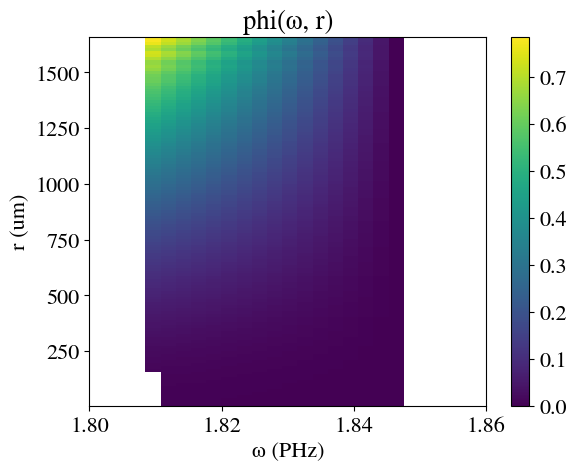

In [193]:
ϕωr = unwrap_phase(Eωr; linear=false)
ϕωr_blanked = blank_phase(grid.ω, abs2.(Eωr), ϕωr; level=0.05)

plt.figure()
plt.pcolormesh(grid.ω.*1e-15, q.r.*1e6, ϕωr_blanked', shading="auto")
plt.colorbar()
# plt.clim(0, -6)
plt.xlim(1.80 , 1.86)
plt.xlabel("ω (PHz)")
plt.ylabel("r (um)")
plt.title("phi(ω, r)")
plt.gcf()

## Comparison input Et of Esmerando vs. luna

In [23]:
# transforming to time domain
Etr = FFTW.irfft(Eωr, length(grid.t), 1)
Et = FFTW.irfft(Eω, length(grid.t), 1)

# Hilbert transform to create the analytical signal which is the compex representation of the real signal
Et_Hilbert = Maths.hilbert(Et)

# Same but using a luna function
# precisely: "Get the envelope time-domain electric field (including the carrier wave) from the frequency-domain field `Eω`."
to, Eto = Processing.getEt(grid, Eω; trange=nothing, oversampling=1, bandpass=nothing, FTL=false)

([-1.3662785339316308e-12, -1.3656114057412345e-12, -1.364944277550838e-12, -1.3642771493604419e-12, -1.3636100211700456e-12, -1.3629428929796492e-12, -1.362275764789253e-12, -1.3616086365988567e-12, -1.3609415084084603e-12, -1.360274380218064e-12  …  1.3596072520276678e-12, 1.360274380218064e-12, 1.3609415084084603e-12, 1.3616086365988567e-12, 1.362275764789253e-12, 1.3629428929796492e-12, 1.3636100211700456e-12, 1.3642771493604419e-12, 1.364944277550838e-12, 1.3656114057412345e-12], ComplexF64[-0.015406191349029541 - 0.0031702518463134766im; -0.0023044347763061523 - 0.015618458390235901im; … ; 0.009678332376955883 + 0.012241579744753359im; -0.00822154441820841 + 0.013337571013310382im;;])

In [24]:
# Checking if energies of input in time and frequency domain are as we want
println(energyfun(Etr).*1e6)
println(energyfun_ω(Eωk).*1e6)

# Checking for fwhm of the pulse
println(Maths.fwhm(grid.t.*1e15, abs2.(Et_Hilbert)))

250.0
250.0000000000258
[150.00353475321222;;]


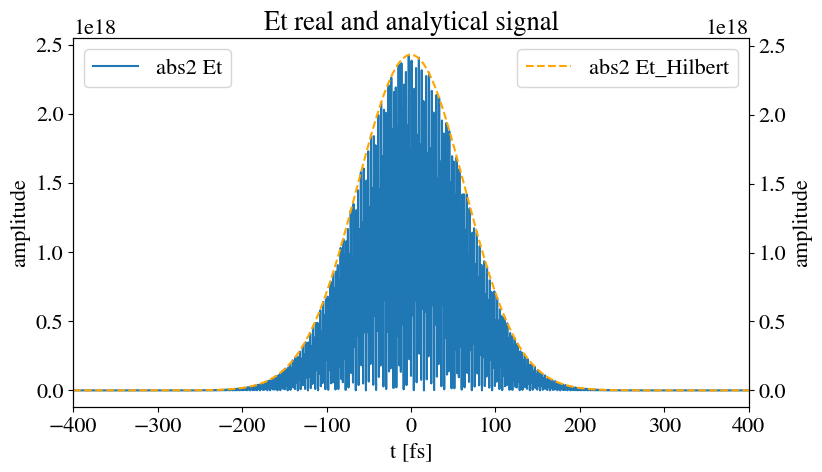

In [25]:
fig, ax1 = plt.subplots(figsize=(8.5, 5))
    ax1.set_title("Et real and analytical signal")
    ax1.plot(grid.t.*1e15, abs2.(Et), label="abs2 Et")
    # ax1.plot(grid.t.*1e15, real.(Et), label="real Et_Hilbert")
    # ax1.plot(grid.t.*1e15, imag.(Et), label="imaginary Et_Hilbert")
    ax2 = ax1.twinx()
    ax2.plot(to.*1e15, abs2.(Et_Hilbert), linestyle="--", color="orange", label="abs2 Et_Hilbert")
    # ax2.plot(to.*1e15, real.(Et_Hilbert), linestyle="--", color="red", label="real Eto")
    # ax2.plot(to.*1e15, imag.(Et_Hilbert), linestyle="--", color="green", label="imaginary Eto")
    ax1.set_xlim(-400 , 400)
    # ax1.set_ylim(0,)#, 50)
    ax1.set_xlabel("t [fs]")
    ax1.set_ylabel("amplitude")
    ax2.set_ylabel("amplitude")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()

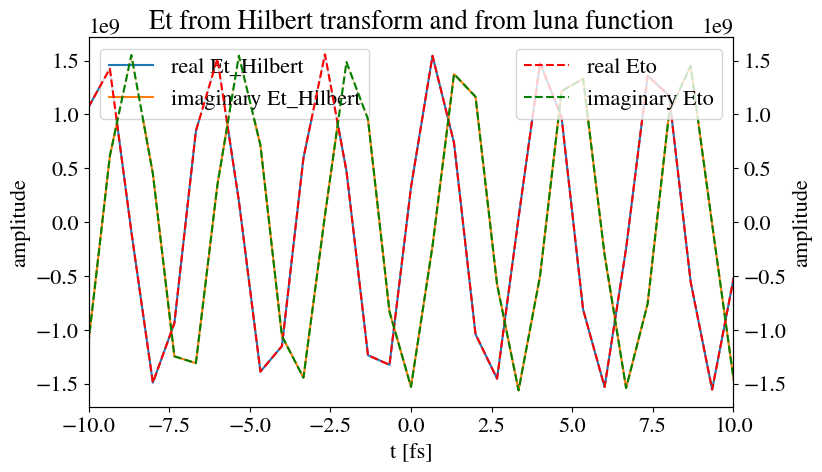

In [26]:
fig, ax1 = plt.subplots(figsize=(8.5, 5))
    ax1.set_title("Et from Hilbert transform and from luna function")
    # ax1.plot(grid.t.*1e15, abs2.(Et_Hilbert), label="abs2 Et_Hilbert")
    ax1.plot(grid.t.*1e15, real.(Et_Hilbert), label="real Et_Hilbert")
    ax1.plot(grid.t.*1e15, imag.(Et_Hilbert), label="imaginary Et_Hilbert")
    ax2 = ax1.twinx()
    # ax2.plot(to.*1e15, abs2.(Eto), linestyle="--", color="orange", label="abs2 Eto")
    ax2.plot(to.*1e15, real.(Eto), linestyle="--", color="red", label="real Eto")
    ax2.plot(to.*1e15, imag.(Eto), linestyle="--", color="green", label="imaginary Eto")
    ax1.set_xlim(-10 , 10)
    # ax1.set_ylim(0,)#, 50)
    ax1.set_xlabel("t [fs]")
    ax1.set_ylabel("amplitude")
    ax2.set_ylabel("amplitude")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()


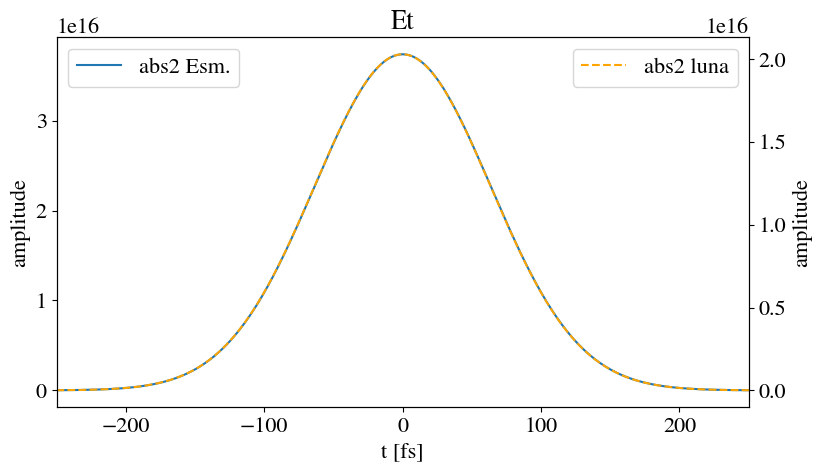

In [27]:
# Comparing input Et from luna and Esmerando

fig, ax1 = plt.subplots(figsize=(8.5, 5))
    ax1.set_title("Et")
    # ax1.plot(t_esm.*1e15, real.(Et_esm), label="real")
    # ax1.plot(t_esm.*1e15, imag.(Et_esm), label="imaginary")
    ax1.plot(t_esm.*1e15, abs2.(Et_esm), label="abs2 Esm.")
    ax2 = ax1.twinx()
    # ax2.plot(grid.t.*1e15, prefac.*abs2.(Et_Hilbert), linestyle="--", color="orange", label="abs2 luna")
    ax2.plot(grid.t.*1e15, prefac.*abs2.(Eto), linestyle="--", color="orange", label="abs2 luna")
    ax1.set_xlim(-250 , 250)
    # ax1.set_ylim(0,)#, 50)
    ax1.set_xlabel("t [fs]")
    ax1.set_ylabel("amplitude")
    ax2.set_ylabel("amplitude")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()



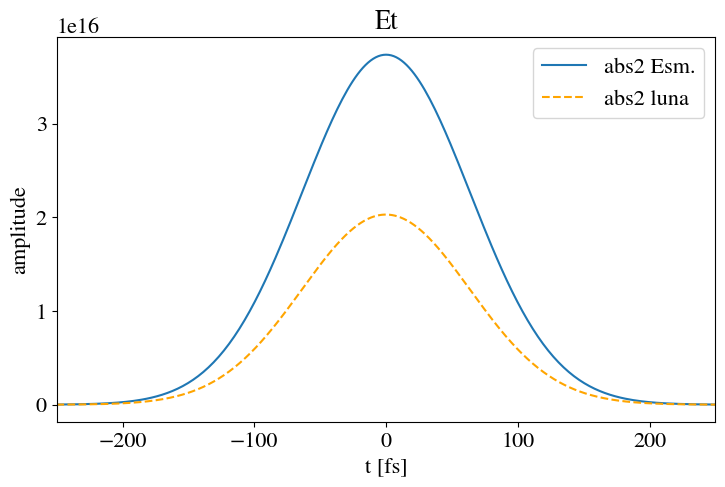

In [28]:
# Comparing input Et from Esmerando and luna (with prefactor)

prefac = 2*pi*PhysData.c*PhysData.ε_0/2

plt.figure(figsize=(8.5, 5))
plt.title("Et")
plt.plot(t_esm.*1e15, abs2.(Et_esm), label="abs2 Esm.")
plt.plot(grid.t.*1e15, prefac.*abs2.(Eto), linestyle="--", color="orange", label="abs2 luna")
plt.xlim(-250 , 250)
plt.xlabel("t [fs]")
plt.ylabel("amplitude")
plt.legend()
plt.gcf()

## Check if pulse energies are still correct for chirped pulse

In [38]:
println(PhysData.wlfreq(1030e-9))

1.8287879294260708e15


In [195]:
ϕs = [0, 0, -30.0e-30]
Eωk_chirped = Fields.prop_taylor(Eωk, grid, ϕs, 1030e-9)
Eωr_chirped = Fields.prop_taylor(Eωr, grid, ϕs, 1030e-9)

# note
#     `integrateR` and `integrateK` fulfill Parseval's theorem, i.e. for some array `A`,
#     `integrateR(abs2.(A), q)` and `integrateK(abs2.(q*A), q)` are equal, **but**
#     `integrateR(A, q)` and `integrateK(q*A, q)` are **not** equal.
Iω_chirped_intk = Hankel.integrateK(abs2.(Eωk_chirped), q; dim=2) 
Iω_chirped_intr = Hankel.integrateR(abs2.(Eωr_chirped), q; dim=2)

Eω_chirped_intk = Hankel.integrateK(Eωk_chirped, q; dim=2) 
Eω_chirped_intr = Hankel.integrateR(Eωr_chirped, q; dim=2)

# Eωr_chirped = q \ Eωk_chirped #Fields.prop_taylor(Eωr, grid, ϕs, λ0) #
Etr_chirped = FFTW.irfft(Eωr_chirped, length(grid.t), 1)

println(energyfun(Etr_chirped).*1e6)
println(energyfun_ω(Eωk_chirped).*1e6)

250.0
250.0000000000258


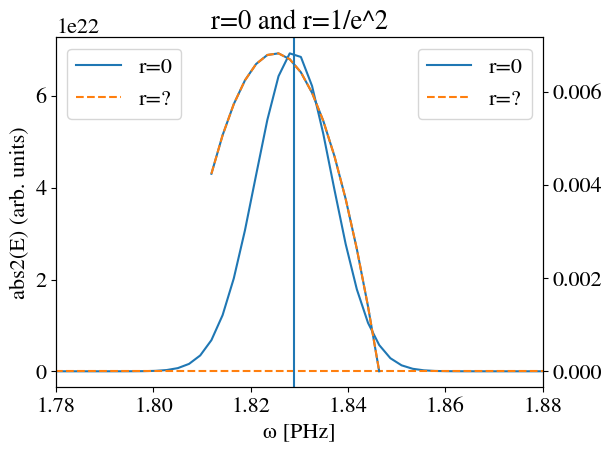

In [222]:
ϕω0 = unwrap_phase(Eωr_chirped[:,1]; linear=false)
ϕω0 = blank_phase(grid.ω, abs2.(Eωr_chirped[:,1]), ϕω0; level=0.05)
ϕωr1 = unwrap_phase(Eωr_chirped[:,end]; linear=false)
ϕωr1 = blank_phase(grid.ω, abs2.(Eωr_chirped[:,end]), ϕω0; level=0.05)

fig, ax1 = plt.subplots()
    ax1.set_title("r=0 and r=1/e^2")
    ax1.plot(grid.ω.*1e-15, abs2.(Eωr_chirped[:,1]), label="r=0")
    ax1.plot(grid.ω.*1e-15, abs2.(Eωr_chirped[:,end]), label="r=?", linestyle="dashed")
    ax2 = ax1.twinx()
    ax2.plot(grid.ω.*1e-15, ϕω0, label="r=0")
    # ax2.plot(grid.ω.*1e-15, ϕωr1.-(-0.125.*(grid.ω.*1e-15.-1.83)), label="r=?", linestyle="dashed")
    ax2.plot(grid.ω.*1e-15, ϕωr1, label="r=?", linestyle="dashed")
    ax1.axvline(1.8287879294260708)
    ax1.set_xlim(1.78 , 1.88)
    ax1.set_xlabel("ω [PHz]")
    ax1.set_ylabel("abs2(E) (arb. units)")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()

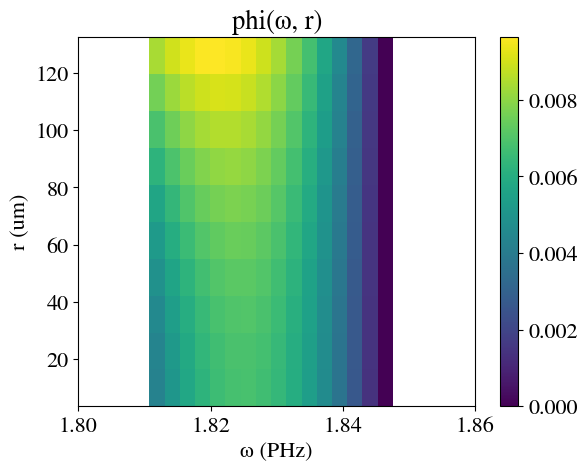

In [221]:
ϕωr = unwrap_phase(Eωr_chirped; linear=false)
ϕωr_blanked = blank_phase(grid.ω, abs2.(Eωr_chirped), ϕωr; level=0.05)

plt.figure()
plt.pcolormesh(grid.ω.*1e-15, q.r[1:10].*1e6, ϕωr_blanked[:,1:10]', shading="auto")
plt.colorbar()
# plt.clim(0, -6)
plt.xlim(1.80 , 1.86)
plt.xlabel("ω (PHz)")
plt.ylabel("r (um)")
plt.title("phi(ω, r)")
plt.gcf()

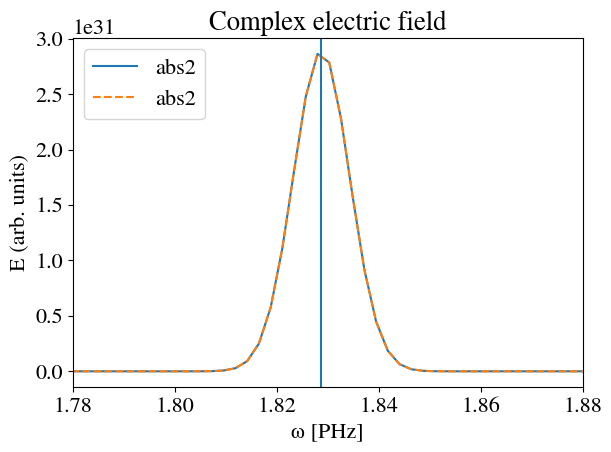

In [79]:
fig, ax1 = plt.subplots()
    ax1.set_title("Complex electric field")
    # ax1.plot(grid.ω.*1e-15, real.(Eω_chirped_intk), label="real")
    # ax1.plot(grid.ω.*1e-15, imag.(Eω_chirped_intk), label="imaginary")
    ax1.plot(grid.ω.*1e-15, abs2.(Iω_chirped_intk), label="abs2")
    # ax1.plot(grid.ω.*1e-15, real.(Eω_chirped_intr), label="real")
    # ax1.plot(grid.ω.*1e-15, imag.(Eω_chirped_intr), label="imaginary")
    ax1.plot(grid.ω.*1e-15, abs2.(Iω_chirped_intr), label="abs2", linestyle="dashed")
    ax1.axvline(1.8287879294260708)
    ax1.set_xlim(1.78 , 1.88)
    ax1.set_xlabel("ω [PHz]")
    ax1.set_ylabel("E (arb. units)")
    ax1.legend(loc="upper left")
    plt.tight_layout()
    plt.gcf()

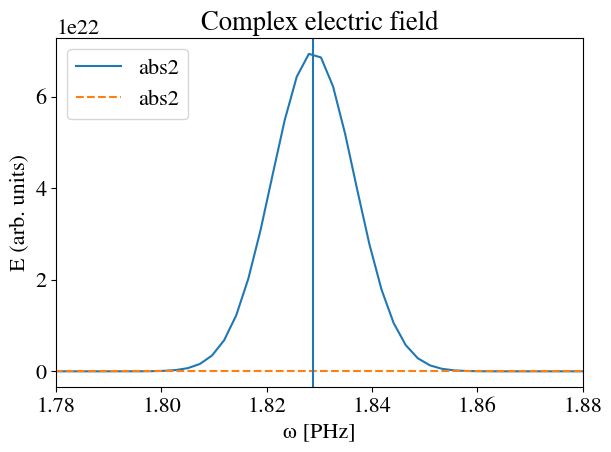

In [111]:
fig, ax1 = plt.subplots()
    ax1.set_title("Complex electric field")
    # ax1.plot(grid.ω.*1e-15, real.(Eω_chirped_intk), label="real")
    # ax1.plot(grid.ω.*1e-15, imag.(Eω_chirped_intk), label="imaginary")
    ax1.plot(grid.ω.*1e-15, abs2.(Eω_chirped_intk), label="abs2")
    # ax1.plot(grid.ω.*1e-15, real.(Eω_chirped_intr), label="real")
    # ax1.plot(grid.ω.*1e-15, imag.(Eω_chirped_intr), label="imaginary")
    ax1.plot(grid.ω.*1e-15, abs2.(Eω_chirped_intr), label="abs2", linestyle="dashed")
    ax1.axvline(1.8287879294260708)
    ax1.set_xlim(1.78 , 1.88)
    ax1.set_xlabel("ω [PHz]")
    ax1.set_ylabel("E (arb. units)")
    ax1.legend(loc="upper left")
    plt.tight_layout()
    plt.gcf()

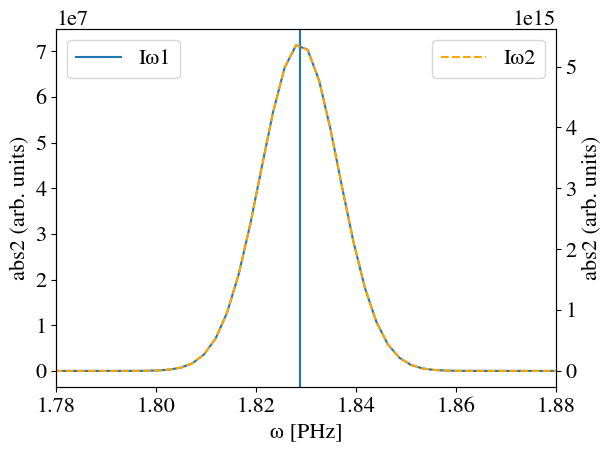

In [109]:
Iω1 = abs2.(Hankel.integrateR(Eωr, q; dim=2))
Iω2 = Hankel.integrateR(abs2.(Eωr), q; dim=2)

fig, ax1 = plt.subplots()
    ax1.set_title("")
    ax1.plot(grid.ω.*1e-15, Iω1, label="Iω1")
    ax1.axvline(1.8287879294260708)
    ax2 = ax1.twinx()
    ax2.plot(grid.ω.*1e-15, Iω2, label="Iω2", color="orange", linestyle="dashed")
    ax1.set_xlim(1.78 , 1.88)
    ax1.set_xlabel("ω [PHz]")
    ax1.set_ylabel("abs2 (arb. units)")
    ax2.set_ylabel("abs2 (arb. units)")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()

In [50]:
# using Polynomials

# p = fit(grid.ω, dropdims(ϕω_blanked, dims=2), 4)
# println(p)
# println("phi2 = ",p[2]*2)

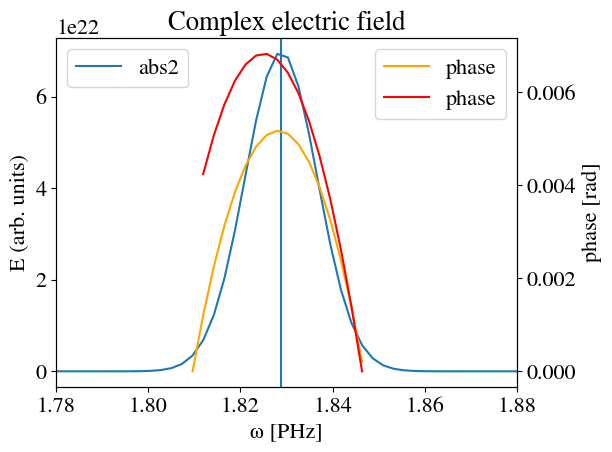

In [66]:
# Eωr_in = Eωr[:, 1]
#ϕωr_in_blanked = ϕωr_blanked[:, 1]

fig, ax1 = plt.subplots()
    ax1.set_title("Complex electric field")
    # ax1.plot(grid.ω.*1e-15, real.(Eω_chirped), label="real")
    # ax1.plot(grid.ω.*1e-15, imag.(Eω_chirped), label="imaginary")
    ax1.plot(grid.ω.*1e-15, abs2.(Eω_chirped), label="abs2")
    ax1.axvline(1.8287879294260708)
    ax2 = ax1.twinx()
    ax2.plot(grid.ω.*1e-15, ϕωk_blanked[:,1], label="phase", color="orange")
    ax2.plot(grid.ω.*1e-15, ϕωr_blanked[:,1], label="phase", color="red")
    ax1.set_xlim(1.78 , 1.88)
    #ax2.set_ylim(-50, 50)
    ax1.set_xlabel("ω [PHz]")
    ax1.set_ylabel("E (arb. units)")
    ax2.set_ylabel("phase [rad]")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.tight_layout()
    plt.gcf()

In [29]:
Iωr = abs2.(Eωr)
Ir = integrate(grid.ω, Iωr, SimpsonEven())
Ir_sym = Hankel.symmetric(Ir, q_1D)
rsym = Hankel.Rsymmetric(q)

257-element Vector{Float64}:
 -0.0016533178199509713
 -0.0016403760176516061
 -0.0016274342155132345
 -0.0016144924135397276
 -0.0016015506117350823
 -0.0015886088101034251
 -0.0015756670086490188
 -0.001562725207376267
 -0.0015497834062897205
 -0.0015368416053940836
  ⋮
  0.0015497834062897205
  0.001562725207376267
  0.0015756670086490188
  0.0015886088101034251
  0.0016015506117350823
  0.0016144924135397276
  0.0016274342155132345
  0.0016403760176516061
  0.0016533178199509713

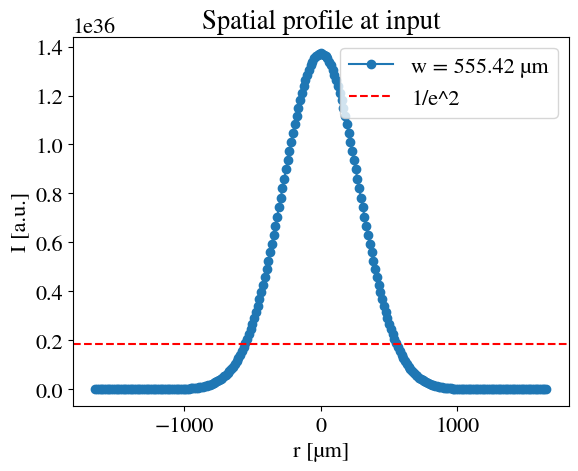

In [30]:
plt.figure()
plt.title("Spatial profile at input")

wz = Maths.fwhm(rsym, Ir_sym, level=1/exp(2), method=:spline) /2
waist_label = @sprintf("w = %.2f µm", wz*1e6)

plt.plot(rsym .*1e6, Ir_sym, label=waist_label, marker="o")

plt.axhline(maximum(Ir_sym)*1/exp(1)^2, color="red", linestyle="--", label="1/e^2")
#plt.axvline(-wz*1e6, color="red", linestyle="--", label="wz")
#plt.axvline(wz*1e6, color="red", linestyle="--", label="wz")


plt.xlabel("r [µm]")
plt.ylabel("I [a.u.]")
plt.legend()
plt.gcf()

## Run simulation, now there is also z dependence

In [31]:
output = Output.MemoryOutput(0, grid.zmax, Nz)

Luna.run(Eωk, grid, linop, transform, FT, output)  # run simulation

┌ Info: Starting propagation
└ @ Luna.RK45 C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\RK45.jl:40
┌ Info: Progress: 1.30 %, ETA: 00:01:22, stepsize 3.60e-03, err 0.00, repeated 0
└ @ Luna.RK45 C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\RK45.jl:55
┌ Info: Progress: 13.45 %, ETA: 00:00:17, stepsize 2.21e-02, err 0.01, repeated 0
└ @ Luna.RK45 C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\RK45.jl:55
┌ Info: Progress: 27.73 %, ETA: 00:00:10, stepsize 2.80e-02, err 0.23, repeated 0
└ @ Luna.RK45 C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\RK45.jl:55
┌ Info: Progress: 33.70 %, ETA: 00:00:09, stepsize 2.28e-02, err 0.45, repeated 1
└ @ Luna.RK45 C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\RK45.jl:55
┌ Info: Progress: 37.69 %, ETA: 00:00:10, stepsize 1.52e-02, err 2.27, repeated 2
└ @ Luna.RK45 C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\RK45.jl:55
┌ Info: Progress: 43.15 %, ETA: 00:00:09, stepsize 9.26e-03, err 0.51, repeated 4
└ @ Luna.RK45 C:\Users\muelderk\.jul

In [32]:
Eωk = output["Eω"]
Eωr = q \ Eωk

2049×128×201 Array{ComplexF64, 3}:
[:, :, 1] =
  -0.00115132+0.0im          …  1.65653e-18+0.0im
 -0.000827453+0.000546982im        4.656e-8+1.10118e-6im
 -0.000174261+0.000295785im      7.65893e-7+1.44911e-6im
   -3.0944e-5-2.29959e-5im        6.1012e-6-6.41392e-6im
   8.07775e-6+1.98398e-5im      -4.78195e-7-2.55829e-6im
   3.47018e-6-4.93503e-6im   …  -1.55688e-6-3.32145e-7im
    5.6708e-6+4.43531e-6im       3.49547e-7-3.20234e-7im
  -5.15116e-5-9.90508e-5im      -9.06195e-7+1.69025e-6im
   1.68465e-5+0.000158693im      1.34289e-6+1.71096e-6im
  -0.00023799-9.46416e-5im      -7.91468e-7-4.03965e-6im
             ⋮               ⋱  
   1.72249e-5-3.30752e-5im   …  -3.00234e-8-4.16824e-7im
  -2.91359e-5+5.11648e-5im       3.69994e-7+4.92681e-7im
   4.89969e-5-8.58952e-5im        2.0492e-7+3.44841e-8im
  -7.38373e-5+0.000133236im      5.10644e-7-1.74793e-7im
  0.000106591-0.000194194im     -7.07116e-7+2.38685e-7im
 -0.000139255+0.000253568im  …   8.27944e-8+1.09897e-7im
  0.000171692-0

In [33]:
# calculate beam size in the center of the cell
Iωr_full = abs2.(Eωr)

Ir_full = zeros(size(Iωr_full,2), size(Iωr_full,3))
for ii = 1:size(Iωr_full, 3)
    Ir_full[:, ii] = integrate(grid.ω, Iωr_full[:, :, ii], SimpsonEven());
end

println(size(Ir_full))

Ir_full_sym = Hankel.symmetric(Ir_full, q_1D)
println(size(Ir_full_sym))
w_full = Maths.fwhm(rsym, Ir_full_sym, level=1/exp(2), method=:spline) /2
println(size(w_full))
println(typeof(w_full))


(128, 201)
(257, 201)
(1, 201)
Matrix{Float64}


In [34]:
zout = output["z"]

201-element Vector{Float64}:
 0.0
 0.0019135454576426011
 0.0038270909152852022
 0.005740636372927804
 0.0076541818305704045
 0.009567727288213005
 0.011481272745855607
 0.013394818203498207
 0.015308363661140809
 0.01722190911878341
 ⋮
 0.36740072786737943
 0.36931427332502204
 0.37122781878266464
 0.37314136424030725
 0.3750549096979498
 0.3769684551555924
 0.378882000613235
 0.3807955460708776
 0.38270909152852023

In [35]:
w_z = zeros(length(w_full))
w_z = vcat(w_full', w_full')

402×1 Matrix{Float64}:
 0.0005554160120943935
 0.0005501061239421958
 0.0005447963936838807
 0.0005394901556853165
 0.0005341844615719181
 0.0005288766272995353
 0.0005235700300032543
 0.0005182652890080059
 0.0005129700959564021
 0.0005076740288210758
 ⋮
 0.0004916484450208821
 0.0004969357004476876
 0.0005022197531519049
 0.0005075127440308292
 0.0005128061565583226
 0.0005180925268332084
 0.0005233819208430866
 0.0005286811603852512
 0.0005339808996456378

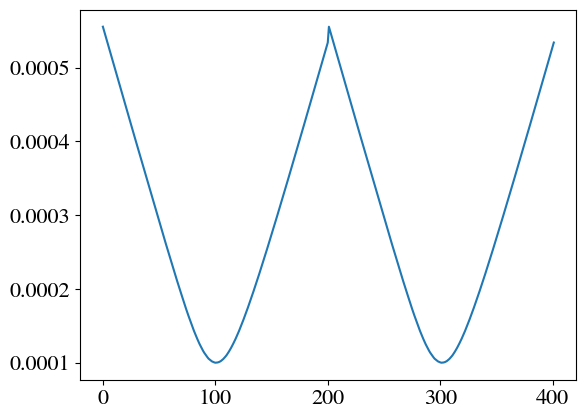

In [36]:
plt.figure()
# plt.plot(w_full')
plt.plot(w_z)
plt.gcf()

In [37]:
output

MemoryOutput["simulation_type", "dumps", "meta", "Eω", "grid", "stats", "z"]

In [38]:
output["simulation_type"]

Dict{String, Any} with 3 entries:
  "field"     => "field-resolved"
  "linop"     => "constant"
  "transform" => "TransRadial\n  grid type: Luna.Grid.RealGrid\n  time grid siz…

In [39]:
output["dumps"]

Dict{String, Any} with 2 entries:
  "linop"     => "Array{ComplexF64}((2049, 128)) ComplexF64[-200.0 + 0.0im -200…
  "transform" => "Luna.NonlinearRHS.TransRadial{Float64, Hankel.QDHT{0, 1, Floa…

In [40]:
output["meta"]

Dict{String, Any} with 2 entries:
  "git_commit" => "unavailable (Luna is not checkout out for development)"
  "sourcecode" => "#= Date: 2025-04-29T15:51:43.264\ngit branch: unavailable (L…

In [41]:
output["stats"]

Dict{String, Any}()